In [1]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Path to dataset files: C:\Users\Skynet\.cache\kagglehub\datasets\jonathanoheix\face-expression-recognition-dataset\versions\1


<h1>NOVO UCITAVANJE PODATAKA SA OVERSAMPLINGOM ZA DISGUST</h1>

In [10]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np
import os
import random

# --- Parametri ---
# train_val_data_dir = r'..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 64
target_class = 'disgust'
target_count = 4000

# --- Učitaj sve slike u memoriju (kao test DS, bez split) ---
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinačne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# --- Razdvoji slike po klasama ---
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# --- Oversampling ciljne klase ---
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# --- Spoji sve klase ---
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# --- Permutacija da batch-evi budu mešani ---
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# --- Stratified split 80/20 po klasama ---
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# --- Permutacija nakon split-a ---
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# --- Kreiraj batch-eve kao image_dataset_from_directory ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  # shuffle pre batch-a
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [11]:
# test DS
batch_size = 64
# test_data_dir = r'..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        
        - training 28821
        
        - validation (test kod nas) 7066

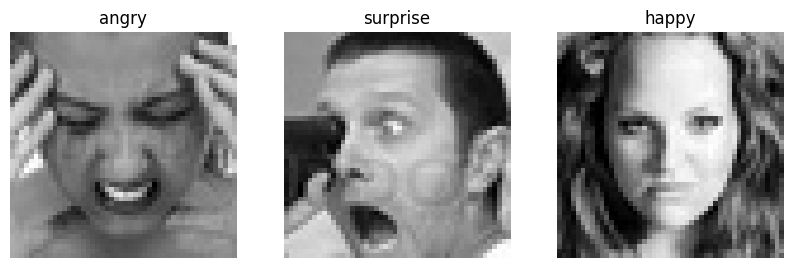

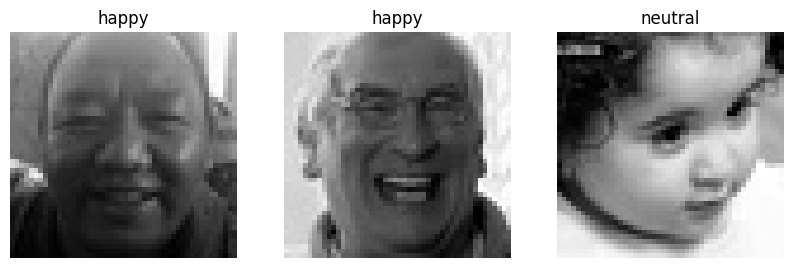

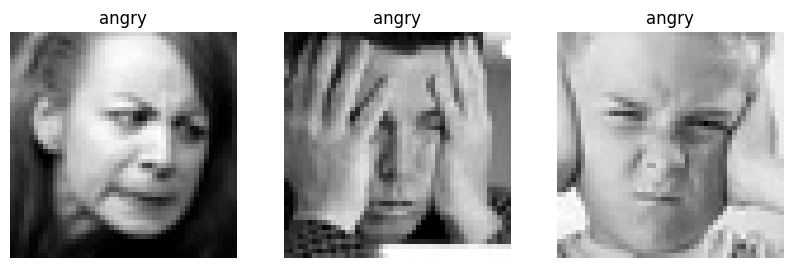

In [12]:
import matplotlib.pyplot as plt

train_class_names = train_ds.class_names
class_names = train_class_names
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

class_names = val_ds.class_names
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


class_names = test_class_names
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [6]:
def count_labels_with_percentage(dataset, class_names):
    counts = dict.fromkeys(class_names, 0)
    total = 0
    
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
        total += len(indices)
    percentages = {cls: f"{(counts[cls]/total)*100:.2f}%" for cls in class_names}
    
    return counts, percentages


train_counts, train_perc = count_labels_with_percentage(train_ds, class_names)
val_counts, val_perc = count_labels_with_percentage(val_ds, class_names)
test_counts, test_perc = count_labels_with_percentage(test_ds, class_names)

print("Train dataset counts:", train_counts)
print("Train dataset %:", train_perc)

print("\nValidation dataset counts:", val_counts)
print("Validation dataset %:", val_perc)

print("\nTest dataset counts:", test_counts)
print("Test dataset %:", test_perc)


Train dataset counts: {'angry': 3194, 'disgust': 3200, 'fear': 3282, 'happy': 5731, 'neutral': 3985, 'sad': 3950, 'surprise': 2564}
Train dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.38%', 'sad': '15.25%', 'surprise': '9.90%'}

Validation dataset counts: {'angry': 799, 'disgust': 800, 'fear': 821, 'happy': 1433, 'neutral': 997, 'sad': 988, 'surprise': 641}
Validation dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.39%', 'sad': '15.25%', 'surprise': '9.89%'}

Test dataset counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Test dataset %: {'angry': '13.59%', 'disgust': '1.57%', 'fear': '14.41%', 'happy': '25.83%', 'neutral': '17.21%', 'sad': '16.12%', 'surprise': '11.28%'}


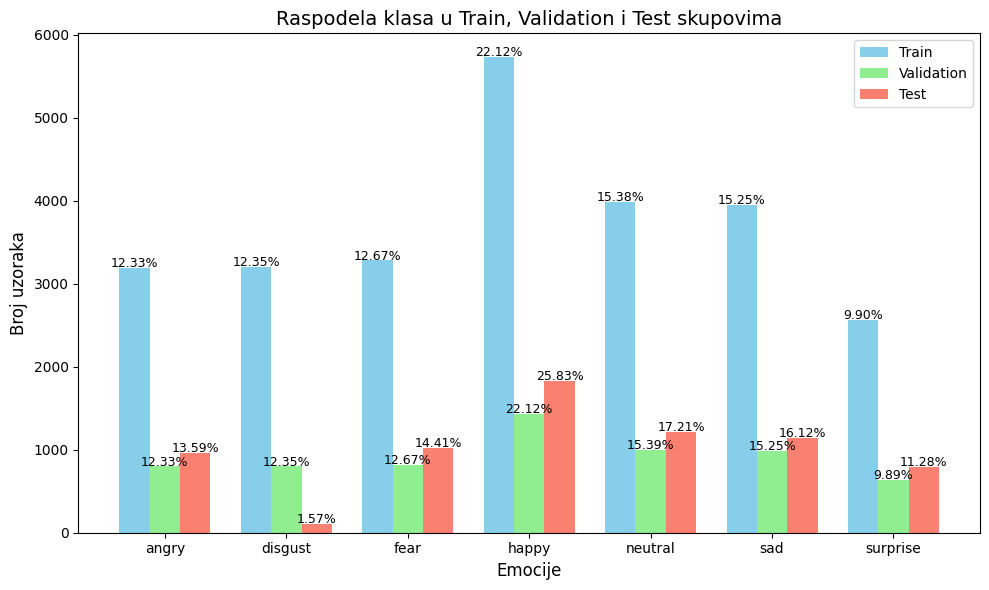

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Lista emocija
emotions = train_ds.class_names

# Konvertujemo counts u listu vrednosti po redosledu emocija
train_values = [train_counts[cls] for cls in emotions]
val_values   = [val_counts[cls] for cls in emotions]
test_values  = [test_counts[cls] for cls in emotions]

# Isto za procente (stringovi)
train_perc_values = [train_perc[cls] for cls in emotions]
val_perc_values   = [val_perc[cls] for cls in emotions]
test_perc_values  = [test_perc[cls] for cls in emotions]

x = np.arange(len(emotions))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(x - width, train_values, width, label='Train', color='skyblue')
ax.bar(x, val_values, width, label='Validation', color='lightgreen')
ax.bar(x + width, test_values, width, label='Test', color='salmon')

ax.set_xlabel('Emocije', fontsize=12)
ax.set_ylabel('Broj uzoraka', fontsize=12)
ax.set_title('Raspodela klasa u Train, Validation i Test skupovima', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

# Dodavanje procenata iznad barova
for i in range(len(emotions)):
    ax.text(x[i]-width, train_values[i]+10, train_perc_values[i], ha='center', fontsize=9)
    ax.text(x[i], val_values[i]+10, val_perc_values[i], ha='center', fontsize=9)
    ax.text(x[i]+width, test_values[i]+10, test_perc_values[i], ha='center', fontsize=9)

plt.tight_layout()
plt.show()


Train sample:


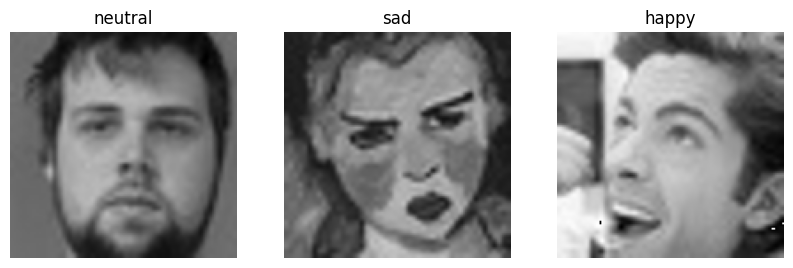

Validation sample:


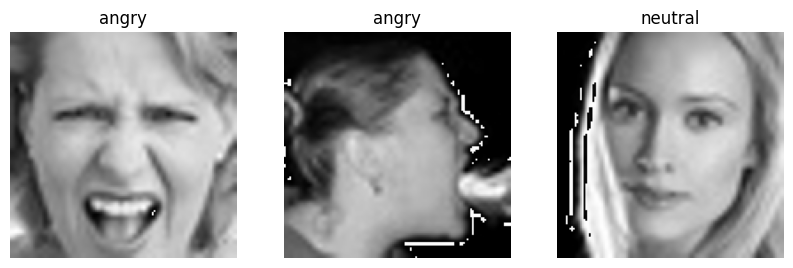

Test sample:


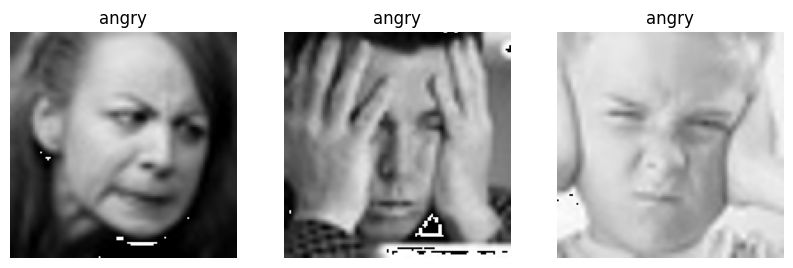

In [13]:
import tensorflow as tf

def grayscale_to_rgb(image, label, target_size=(128,128)):
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, target_size, method='bicubic') 
    return image, label

train_ds_rgb = train_ds.map(grayscale_to_rgb)
val_ds_rgb = val_ds.map(grayscale_to_rgb)
test_ds_rgb = test_ds.map(grayscale_to_rgb)


import matplotlib.pyplot as plt

def show_images(dataset, class_names, n=3):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()

print("Train sample:")
show_images(train_ds_rgb, class_names)

print("Validation sample:")
show_images(val_ds_rgb, class_names)

print("Test sample:")
show_images(test_ds_rgb, class_names)

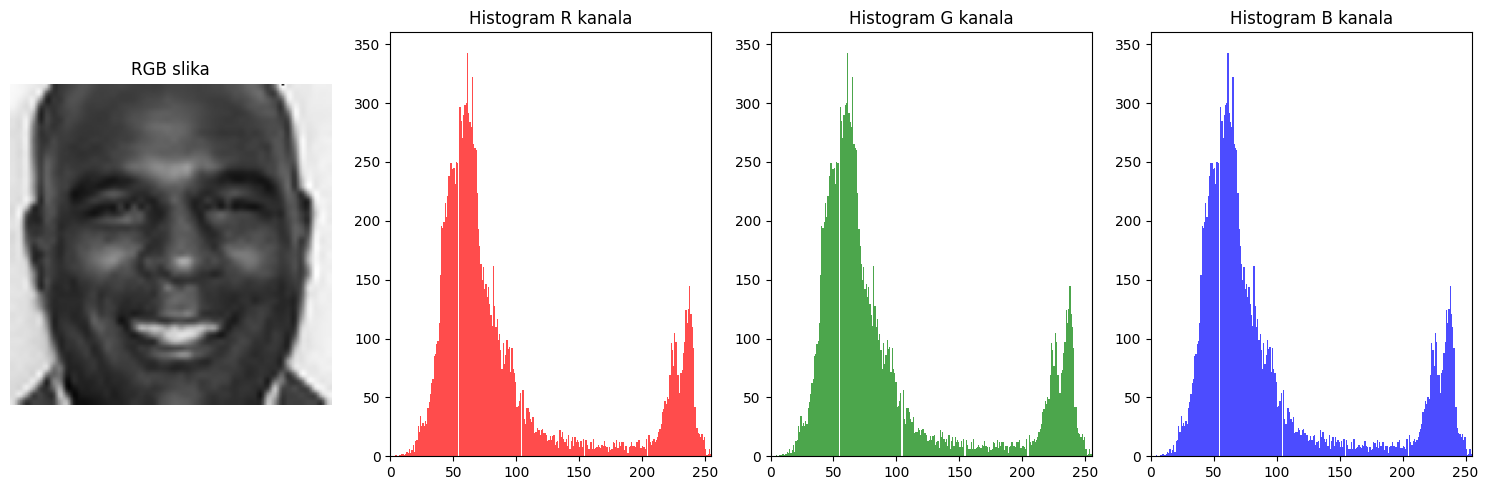

In [14]:
import matplotlib.pyplot as plt

# Uzmi jednu sliku iz train_ds_rgb
for images, labels in train_ds_rgb.take(1):
    image = images[0].numpy().astype("uint8")  # prva slika
    break

plt.figure(figsize=(15,5))

# Prikaži sliku
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("RGB slika")
plt.axis("off")

# Histogram za svaki kanal
colors = ("r", "g", "b")
for i, col in enumerate(colors):
    plt.subplot(1, 4, i+2)
    plt.hist(image[:, :, i].ravel(), bins=256, color=col, alpha=0.7)
    plt.title(f"Histogram {col.upper()} kanala")
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()

In [10]:
# import tensorflow as tf

# # --- AUGMENTACIJA ---
# def augment(image, label):
#     # svi prolaze kroz augmentaciju
#     return data_augmentation(image, training=True), label

# # --- REPEAT FACTORS --- 
# # isti redosled kao train_class_names
# repeat_factors_list = []
# for cname in train_class_names:
#     repeat_factors_list.append({
#         'fear': 2,        # 1 original + 2 extra
#         'surprise': 2,
#         'angry': 1,
#         'disgust': 2,
#         'happy': 1,
#         'sad': 1,
#         'neutral': 1
#     }.get(cname, 1))      # default = 1
# repeat_factors = tf.constant(repeat_factors_list, dtype=tf.int32)

# # --- HELPER: augmentacija sa repeat ---
# def augment_with_repeat(image, label):
#     class_idx = tf.argmax(label)
#     reps = tf.cast(repeat_factors[class_idx], tf.int64)

#     # dataset sa 'reps' augmentacija tog primera
#     ds = tf.data.Dataset.from_tensors((image, label)) \
#         .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
#         .repeat(reps)

#     return ds

# # --- BALANSIRANI DATASET ---
# train_ds_balanced = (
#     train_ds_rgb.unbatch()
#     .flat_map(augment_with_repeat)  # svaki primer se proširi u 'reps' augmentacija
#     .shuffle(1000)
#     .batch(batch_size)
#     .prefetch(tf.data.AUTOTUNE)
# )

# train_ds_rgb = train_ds_balanced

# # --- PROVERA BROJA PRIMERA ---
# count = sum(images.shape[0] for images, labels in train_ds_rgb)
# val_count = sum(images.shape[0] for images, labels in val_ds_rgb)
# test_count = sum(images.shape[0] for images, labels in test_ds_rgb)

# print("Train:", count, "Validation:", val_count, "Test:", test_count)


In [11]:
# train_counts, train_perc = count_labels_with_percentage(train_ds_rgb, class_names)
# val_counts, val_perc = count_labels_with_percentage(val_ds_rgb, class_names)
# test_counts, test_perc = count_labels_with_percentage(test_ds_rgb, class_names)

# print("Train dataset counts:", train_counts)
# print("Train dataset %:", train_perc)

# print("\nValidation dataset counts:", val_counts)
# print("Validation dataset %:", val_perc)

# print("\nTest dataset counts:", test_counts)
# print("Test dataset %:", test_perc)

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomTranslation(0.1, 0.1),
#     layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])


inputs = layers.Input(shape=(128,128,3))

x = data_augmentation(inputs)    
x = tf.keras.applications.resnet50.preprocess_input(inputs)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)


model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    batch_size = batch_size,
    callbacks=[early_stop, lr_scheduler, checkpoint],
)

loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 379s 929ms/step - accuracy: 0.4351 - auc: 0.7909 - loss: 1.5542 - precision: 0.5949 - recall: 0.2529 - val_accuracy: 0.5064 - val_auc: 0.8364 - val_loss: 1.3742 - val_precision: 0.6661 - val_recall: 0.3246 - learning_rate: 0.0010
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 210s 501ms/step - accuracy: 0.5250 - auc: 0.8551 - loss: 1.2966 - precision: 0.6851 - recall: 0.3461 - val_accuracy: 0.5311 - val_auc: 0.8561 - val_loss: 1.2923 - val_precision: 0.6888 - val_recall: 0.3629 - learning_rate: 0.0010
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 134s 331ms/step - accuracy: 0.5632 - auc: 0.8759 - loss: 1.2047 - precision: 0.7187 - recall: 0.3887 - val_accuracy: 0.5518 - val_auc: 0.8665 - val_loss: 1.2489 - val_precision: 0.6982 - val_recall: 0.3942 - learning_rate: 0.0010
Epoch 4/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 134s 330ms/step - accuracy: 0.5821 - auc: 0.8867 - loss: 1.1535 - precision: 0.7306 - recall: 0.4186 - val_accuracy: 0.5532 - val_auc: 0.8700 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

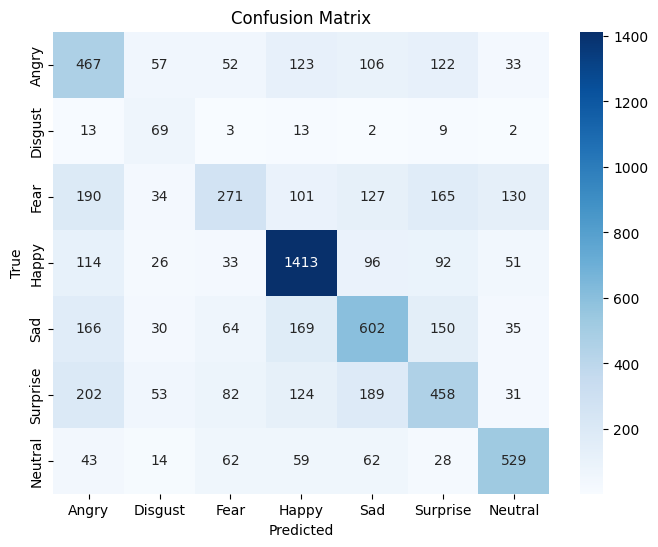

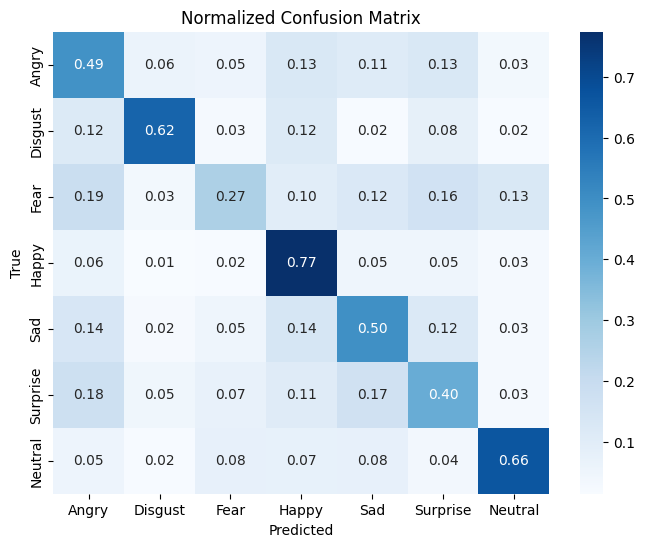

              precision    recall  f1-score   support

       Angry       0.39      0.49      0.43       960
     Disgust       0.24      0.62      0.35       111
        Fear       0.48      0.27      0.34      1018
       Happy       0.71      0.77      0.74      1825
         Sad       0.51      0.50      0.50      1216
    Surprise       0.45      0.40      0.42      1139
     Neutral       0.65      0.66      0.66       797

    accuracy                           0.54      7066
   macro avg       0.49      0.53      0.49      7066
weighted avg       0.54      0.54      0.53      7066

Macro F1 score: 0.4924529284502312
Weighted F1 score: 0.5331847059854267
Macro precision: 0.48947889846562787
Weighted precision: 0.5412443263824873
Macro recall: 0.5299209577251266
Weighted recall: 0.5390602887064817
Accuracy: 0.5390602887064817
AUC score: 0.8459700004860824


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

y_true = []
y_pred = []
y_pred_probs = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

# Cinfusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


#Report
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro F1 score:", f1)

weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted F1 score:", weighted_f1)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro precision:", macro_precision)
weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted precision:", weighted_precision)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro recall:", macro_recall)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted recall:", weighted_recall)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
auc_global = roc_auc_score(np.eye(len(class_names))[y_true], y_pred_probs, multi_class='ovr')
print("AUC score:", auc_global)


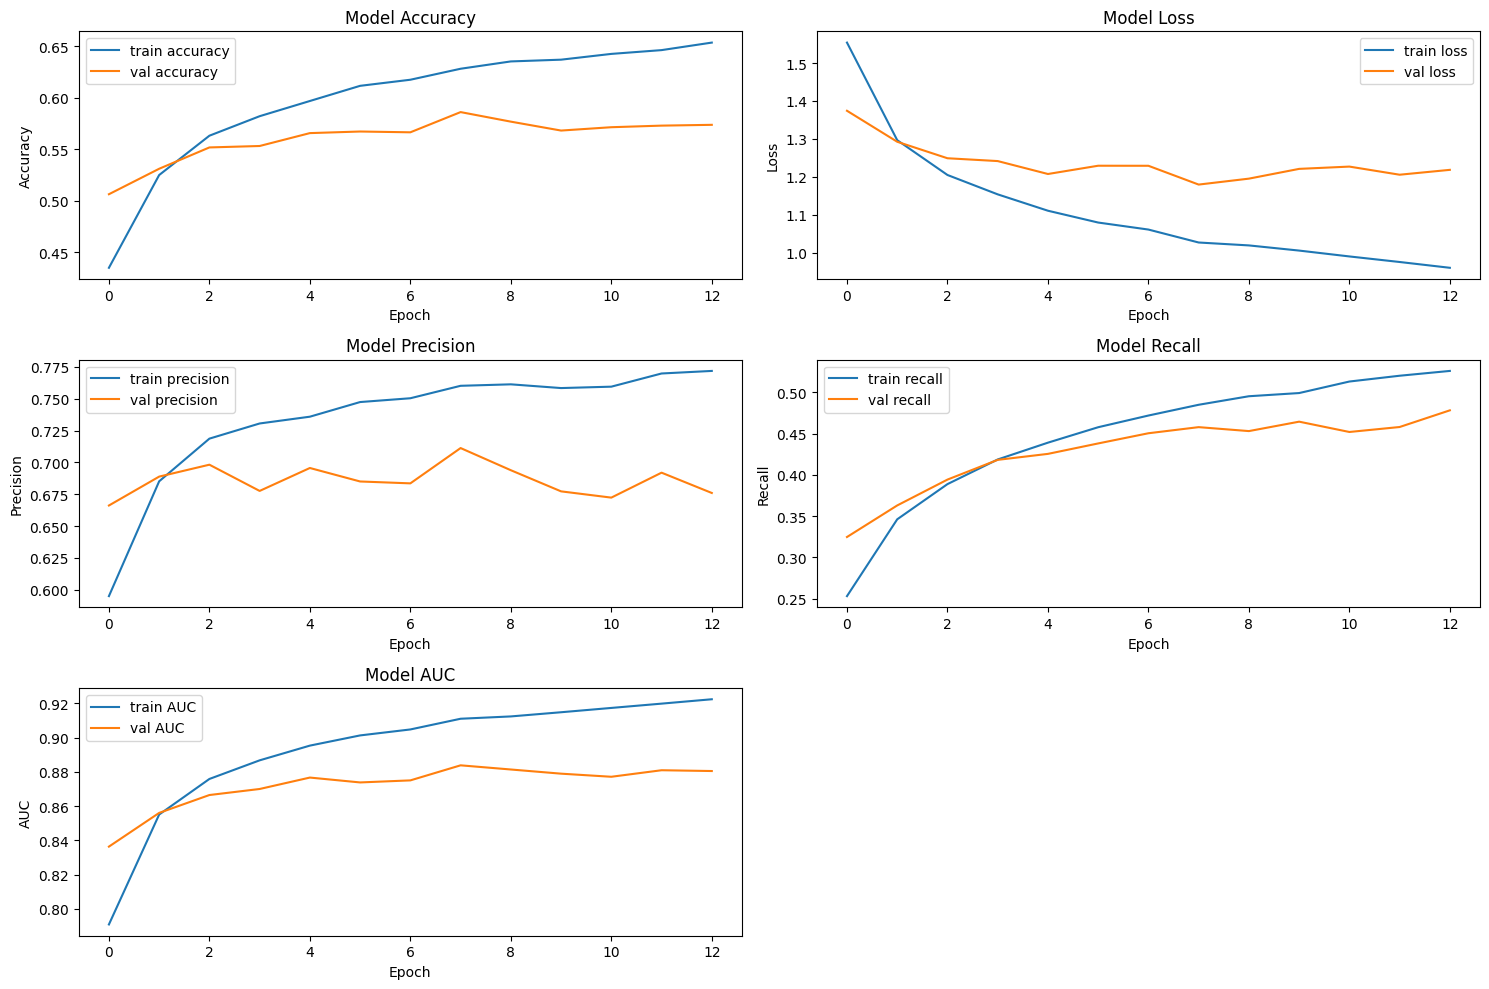

In [19]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

In [22]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 128, 128,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │     14,343 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,630,743 (90.14 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 28,688 (112.07 KB)

In [22]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_17[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import load_model

# model = load_model("best_model.keras")
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith(("conv5_block1", "conv5_block2", "conv5_block3")):   #layer4
        set_trainable = True

    if set_trainable:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    else:
        layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

checkpoint = ModelCheckpoint("resnet_ft.keras", monitor='val_loss', save_best_only=True)
history_finetune = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# Evaluacija
loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Fine-tuned ->  Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 243s 586ms/step - accuracy: 0.6696 - auc: 0.9300 - loss: 0.9145 - precision: 0.7940 - recall: 0.5389 - val_accuracy: 0.6240 - val_auc: 0.9060 - val_loss: 1.0642 - val_precision: 0.7305 - val_recall: 0.5107 - learning_rate: 1.0000e-05
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 217s 537ms/step - accuracy: 0.7524 - auc: 0.9596 - loss: 0.7033 - precision: 0.8566 - recall: 0.6475 - val_accuracy: 0.6337 - val_auc: 0.9118 - val_loss: 1.0439 - val_precision: 0.7285 - val_recall: 0.5445 - learning_rate: 1.0000e-05
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 219s 541ms/step - accuracy: 0.8188 - auc: 0.9769 - loss: 0.5428 - precision: 0.9021 - recall: 0.7350 - val_accuracy: 0.6452 - val_auc: 0.9136 - val_loss: 1.0513 - val_precision: 0.7207 - val_recall: 0.5623 - learning_rate: 1.0000e-05
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 217s 536ms/step - accuracy: 0.8742 - auc: 0.9879 - loss: 0.4073 - precision: 0.9331 - recall: 0.8110 - val_accuracy: 0.6362 - val_auc: 0.9

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

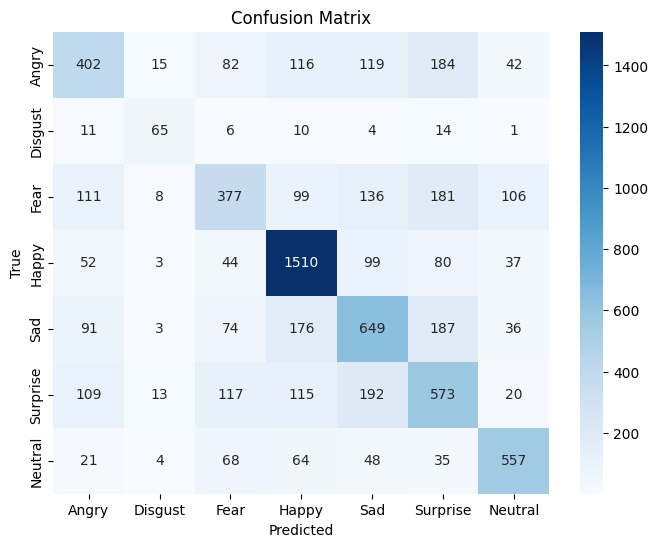

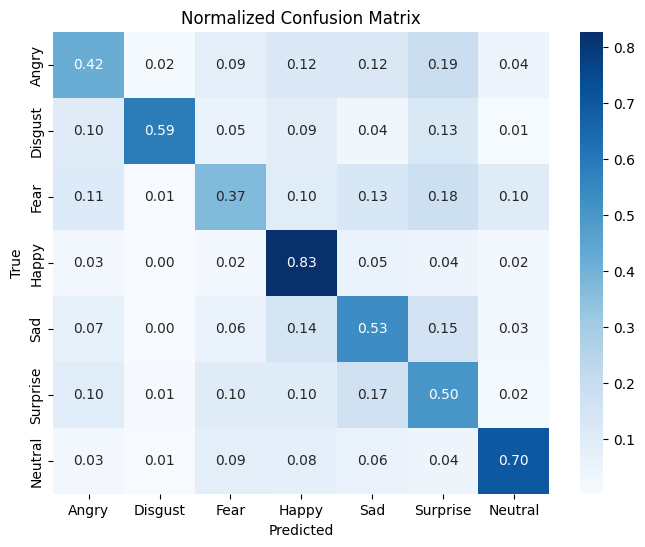

              precision    recall  f1-score   support

       Angry       0.50      0.42      0.46       960
     Disgust       0.59      0.59      0.59       111
        Fear       0.49      0.37      0.42      1018
       Happy       0.72      0.83      0.77      1825
         Sad       0.52      0.53      0.53      1216
    Surprise       0.46      0.50      0.48      1139
     Neutral       0.70      0.70      0.70       797

    accuracy                           0.58      7066
   macro avg       0.57      0.56      0.56      7066
weighted avg       0.58      0.58      0.58      7066

Macro F1 score: 0.5629485231693172
Weighted F1 score: 0.5780432074172734
Macro precision: 0.5682655410166748
Weighted precision: 0.576903739343773
Macro recall: 0.5625325108063508
Weighted recall: 0.5849136711010473
Accuracy: 0.5849136711010473
AUC score: 0.8678229880062753


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


y_true = []
y_pred = []
y_pred_probs = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Normalized confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


#Report
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro F1 score:", f1)

weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted F1 score:", weighted_f1)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro precision:", macro_precision)
weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted precision:", weighted_precision)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
print("Macro recall:", macro_recall)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
print("Weighted recall:", weighted_recall)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
auc_global = roc_auc_score(np.eye(len(class_names))[y_true], y_pred_probs, multi_class='ovr')
print("AUC score:", auc_global)


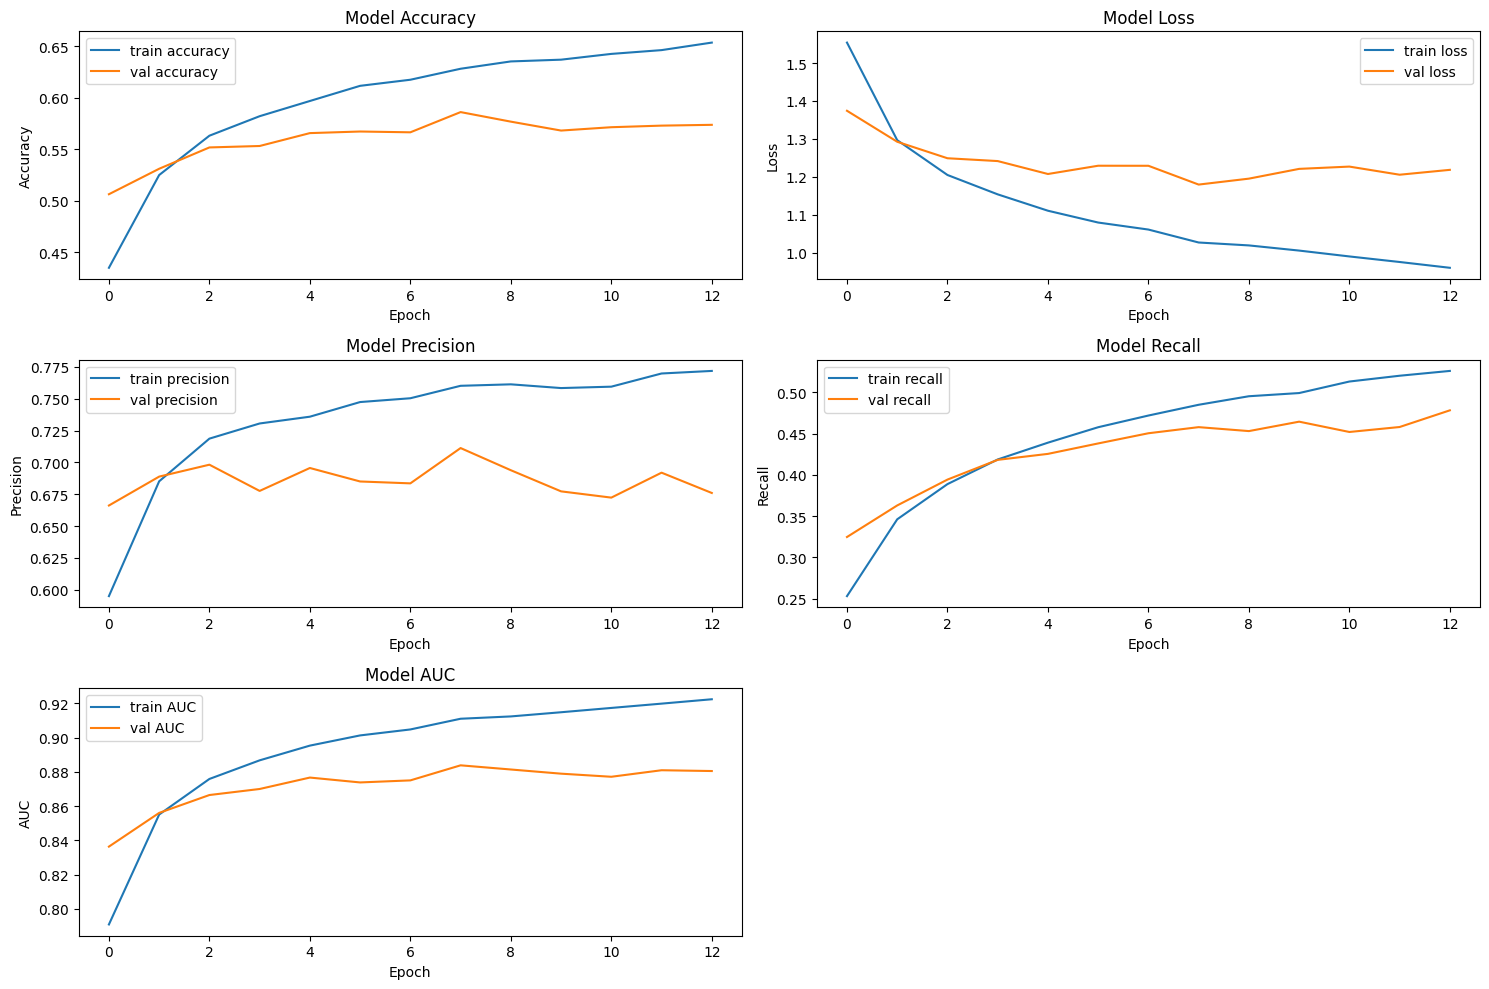

In [25]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

In [26]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 128, 128)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 128, 128,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │     14,343 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,537,687 (204.23 MB)

 Trainable params: 14,967,815 (57.10 MB)

 Non-trainable params: 8,634,240 (32.94 MB)

 Optimizer params: 29,935,632 (114.20 MB)